## Assignment 1:In this assignment, we construct **dense neural networks** for classifying images from the `MNIST` dataset: [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/). The MNIST database consists of a set of 70,000 small (28x28 pixel) grayscale images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

> In **EXPERIMENTS 1 to 3**, we consider `dense neural network` models with one hidden layer. We start with one node in this hidden layer and progressively increase the number of (hidden) nodes in the layer until we find the "best" model in Experiment 3.

> 
But our goal in these `three` experiments is *not only* to find the "best" `dense neural network` model with one hidden but *also* to explore what the node(s) in the hidden layer are "detecting" and what their outputs (i.e. `activation values`) contribute to the final classification of an image. These are examples of intrinsic `local explanations` and `global explanations` , respectively, as described in this recent survey article:

[https://cacm.acm.org/magazines/2020/1/241703-techniques-for-interpretable-machine-learning/fulltext](https://cacm.acm.org/magazines/2020/1/241703-techniques-for-interpretable-machine-learning/fulltext)

To determine what the hidden node is "detecting" we use gradient descent to find a visual pattern that maximizes the activation value of the hidden node, i.e. the visual pattern that the hidden node is maximally responsive to. In this case, the exercise is probably not very insightful. But in `Assignment 2`  we will repeat this analysis with "clusters of nodes" (`convnet filters`) in `convolutional neural network` models. By the examining the patterns that each convnet filter is maximally responsive (but also by visualizing the convnet activations for particular test images) we should be able to determine what (some of) the filters in the `CCN` model are up to.

the (activation values of the) hidden nodes (actually, groups of hidden nodes corresponding or *convnet filters*) can be visualized in various ways to show what "features" (edges, texture, etc.) of the input images they capture.

> In **EXPERIMENT 4** we use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from `Experiment 3` to 154 inputs nodes and train it on the new lower dimensional data.

> In **EXPERIMENT 5** we use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' `dense neural network` using these 70 features and compare its performance to the the DNN models from EXPERIMENTS 3 and 4.

> 
Here are more details for the first `three` experiments:

**EXPERIMENT 1**: Our `dense neural network` will consist of 784 input nodes, a hidden layer with `1 node` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we group the 60,000 `activation values` of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a `boxplot`. We expect the overlap between the range of values in the "boxes" to be minimal. In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on `CNN` models in `Assignment 2`.

**EXPERIMENT 2**: This time our `dense neural network` will have 784 input nodes, a hidden layer with `2 nodes` and 10 output nodes (corresponding to the 10 digits). For each of the 60,000 images, the output of the two hidden nodes are plotted using a `scatterplot`. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in `EXPERIMENT 1`, the color clusters should have very little overlap.

**NOTE**: For EXPERIMENTS 1 &amp; 2 we also perform the following additional tasks:

> 
> 
> * We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.
> 
> * For each model we obtain the confusion matrix and use it to display sample images of true vs false positives and negatives.
> 
> 
> 
> 

* **EXPERIMENT 3**: Students can experiment with more hidden nodes (in the hidden layer) to obtain the `best` model. This `final` model will be used in EXPERIMENTS 4 &amp; 5.

**References**:
[https://github.com/fchollet/deep-learning-with-python-notebooks](https://github.com/fchollet/deep-learning-with-python-notebooks) (2.1 &amp; 5.4)

## Import packages needed (and set seed)Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
keras.__version__

'3.8.0'

In [2]:
tf.__version__

'2.19.0'

In [3]:
tf.config.run_functions_eagerly(True) 

In [4]:
import numpy as np
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## The MNIST datasetThe MNIST dataset of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It comes prepackaged as part of tf.Keras. Use the `mnist.load_data()` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [5]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# EXPERIMENT  2:Our `DNN` will consist of 784 input nodes, a hidden layer with `2 nodes` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation.

For each of the 60,000 training images, the output of the two hidden nodes are plotted using a scatterplot. We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in EXPERIMENT 1, the color clusters should have very little overlap.

## Preparing the dataBefore training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the [0, 1] interval.

Our training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval.

We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [6]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

## Validating our approachSince we will be using categorical_crossentropy as the loss function we need to use to_categorical to convert the class vector of lables to binary matrix representation.

We set apart 5,000 samples of our training data to use as a validation set. Since we will be using `sparse_categorical_crossentropy` as the loss function we **do not** need to use `to_categorical` to convert the class vector of labels to binary matrix representation.

In [7]:
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Building our networkHere our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers.

The first `Dense` layer, the hidden layer, consists of `2 nodes`.

The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current digit image belongs to one of our 10 digit classes.

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))

/opt/miniconda3/envs/LLMs/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-17 22:47:33.615806: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-04-17 22:47:33.615831: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2025-04-17 22:47:33.615835: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
I0000 00:00:1744955253.615845 4290603 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744955253.615860 4290603 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB 

In [9]:
keras.utils.plot_model(model, "mnist_model_2hnode.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Compiling the modelTo make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.

* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.

* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [10]:
model.compile(optimizer='rmsprop',
#                 loss='categorical_crossentropy',
                loss='sparse_categorical_crossentropy',              
                metrics=['accuracy'])

## Training the modelWe are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 30 epochs with batch size 32 (the default).

In [11]:
history = model.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels))

Epoch 1/30


/opt/miniconda3/envs/LLMs/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.3243 - loss: 1.8227 - val_accuracy: 0.4608 - val_loss: 1.3691
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.4540 - loss: 1.3607 - val_accuracy: 0.5334 - val_loss: 1.2530
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5268 - loss: 1.2639 - val_accuracy: 0.5752 - val_loss: 1.1889
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5674 - loss: 1.2058 - val_accuracy: 0.5940 - val_loss: 1.1533
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5876 - loss: 1.1723 - val_accuracy: 0.6048 - val_loss: 1.1323
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5971 - loss: 1.1513 - val_accuracy: 0.6164 - val_loss: 1.1180
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.6052 - loss: 1.1375 - val_accuracy: 0.6200 - val_loss: 1.1084
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.6119 - loss: 1.12

## Testing the modelEvaluate the model on the test dataset.

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6467 - loss: 1.1524


In [13]:
print(f'test acc: {test_acc}, test loss: {test_loss}')  # Note very good...

test acc: 0.6735000014305115, test loss: 1.0632747411727905


## Plotting the performanceWe use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

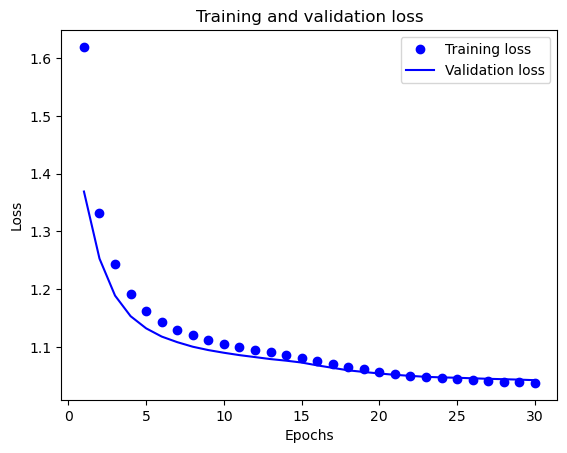

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

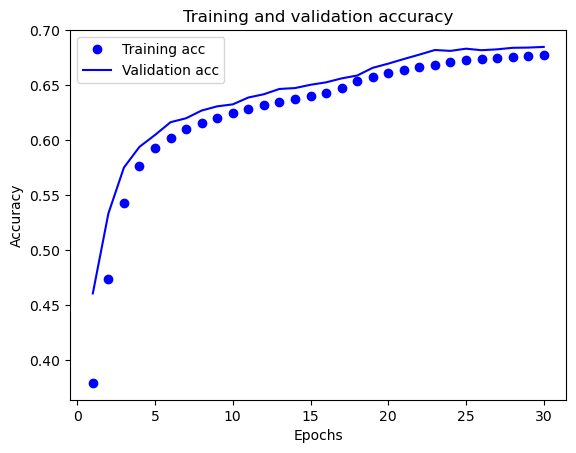

In [16]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Confusion matrixLet us see what the confusion matrix looks like. Using both `sklearn.metrics` and `tensorflow`. Then we visualize

In [17]:
# Get the predicted classes:
pred_probs = model.predict(train_images)
pred_classes = np.argmax(pred_probs, axis=1)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [18]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[4477,   10,  336,  490,    2,   75,   10,    0,   44,    0],
       [   6, 5705,   25,   13,  171,   16,   55,    6,  166,   16],
       [ 711,  101, 3315,  150,   31,  201,  489,   10,  456,    6],
       [ 564,   21,  145, 3602,   53,  716,   11,  165,  285,   76],
       [   7,  389,   32,    7, 3772,   48,   14,   17,  198,  823],
       [ 303,   34,  277, 1684,   47, 1501,   41,  143,  858,   99],
       [  16,  230,  655,    7,    4,   21, 4207,    0,  277,    0],
       [   8,   29,    2,  256,  123,  107,    0, 4520,   39,  631],
       [  66,  810,  255,  302,  180,  659,  173,   14, 2876,   54],
       [  15,   37,   10,   89, 1100,   92,    3,  574,   79, 3455]])

In [19]:
# # Apparently the line I added: tf.compat.v1.disable_eager_execution()
# # broke this. But I don't really need to do this since I can use sklearn.
# conf_mx2 = tf.math.confusion_matrix(train_labels, pred_classes)
# conf_mx2

## Visualizing the confusion matrixWe use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. [https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates.

See [https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter)

In [20]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

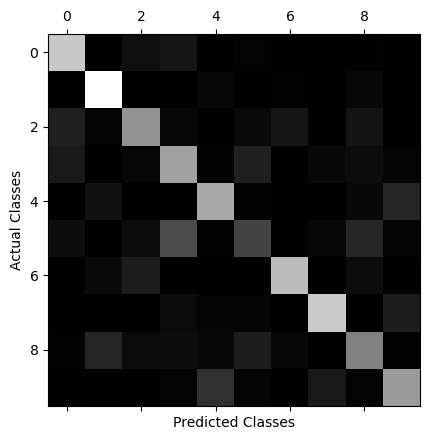

In [21]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
# plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [22]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

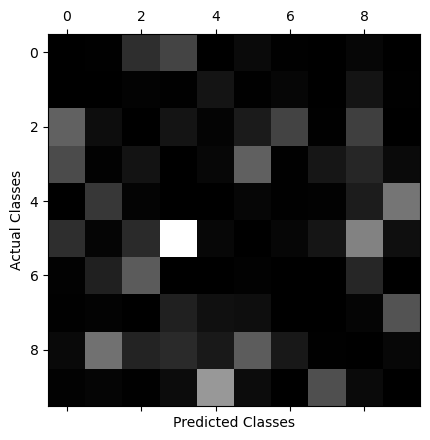

In [23]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
# plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

In [24]:
def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

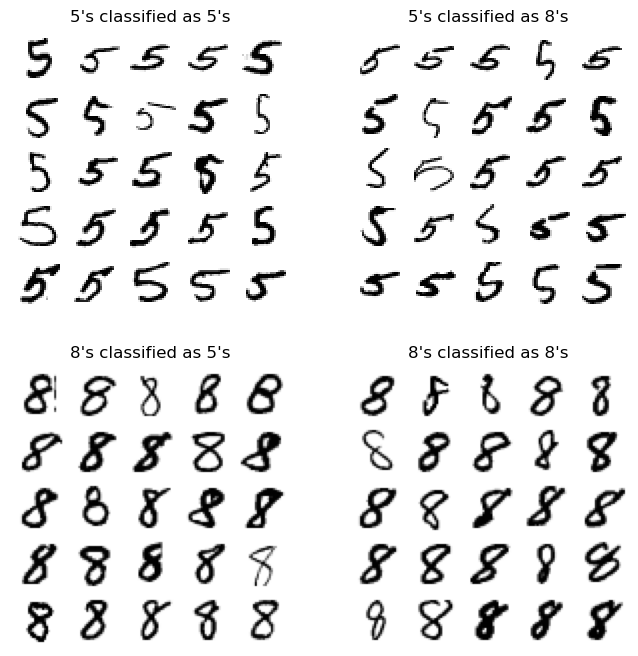

In [25]:
cl_a, cl_b = 5,8
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

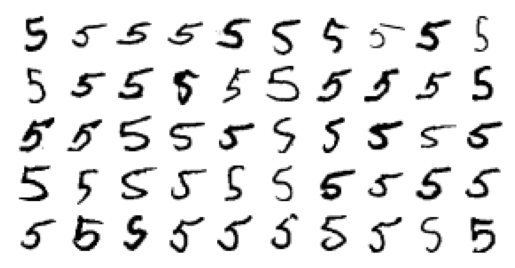

In [26]:
# display 50 of the 5's classified correctly
plot_digits(X_aa[:50],plt,images_per_row = 10)

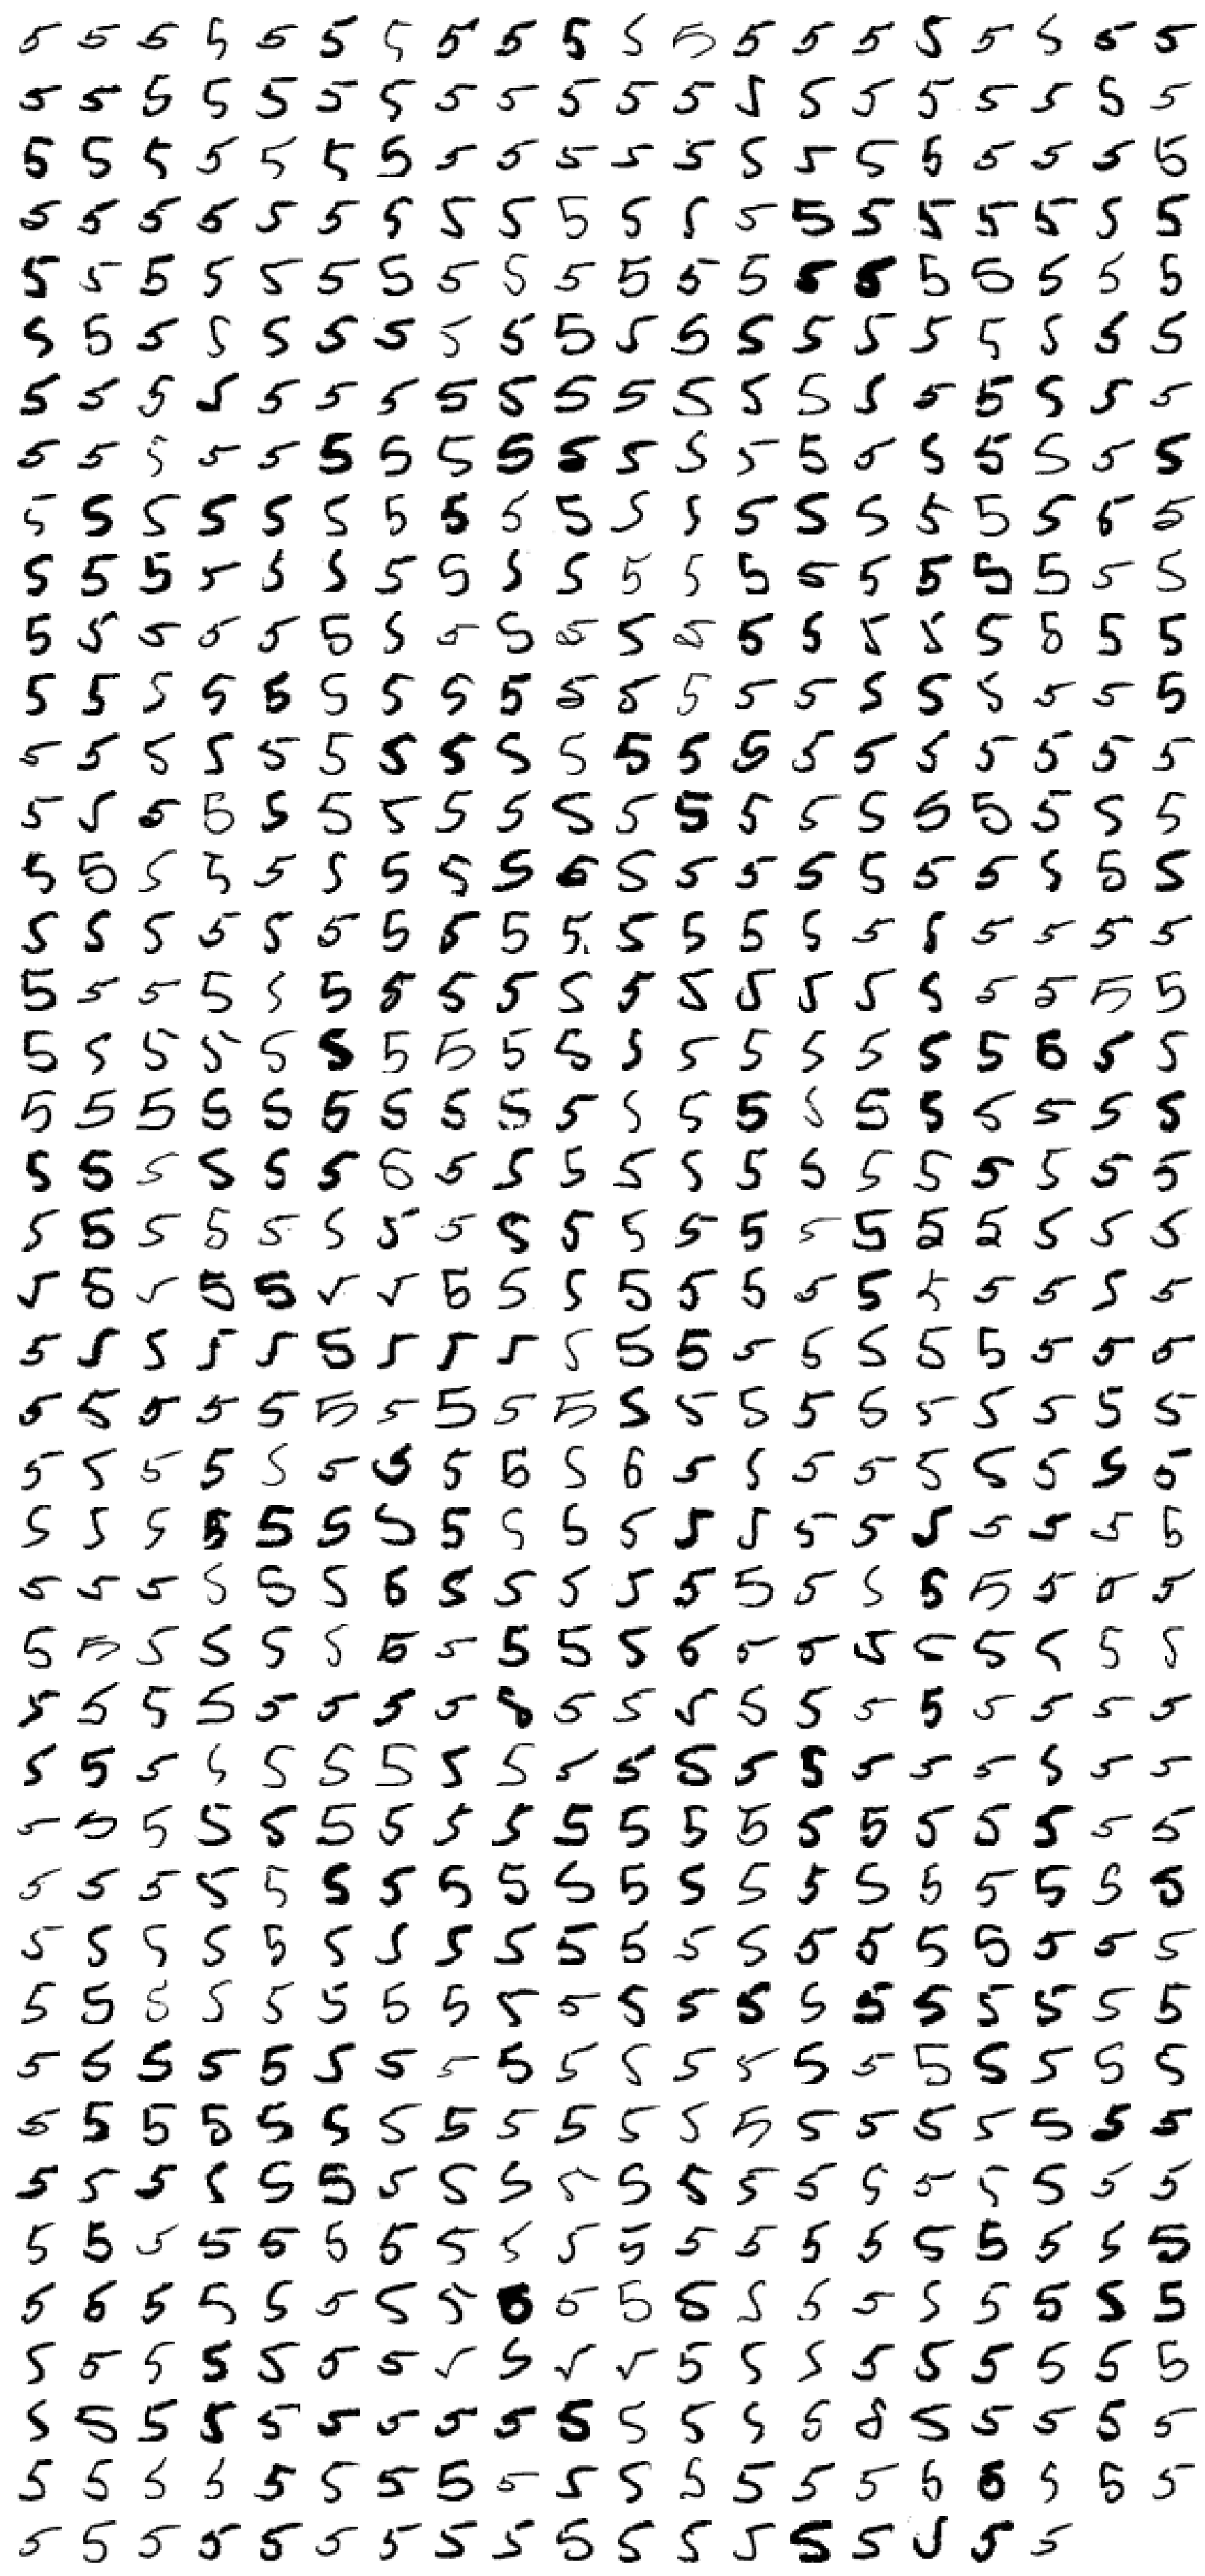

In [27]:
# display all the 5's classified as 8's
num = X_ab.shape[0]
plt.figure(figsize=(50,50))
plot_digits(X_ab[:num],plt, images_per_row = 20)

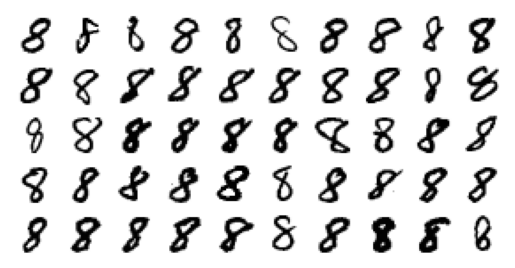

In [28]:
# display 50 of the 8's classified correctly
plot_digits(X_bb[:50],plt, images_per_row = 10)

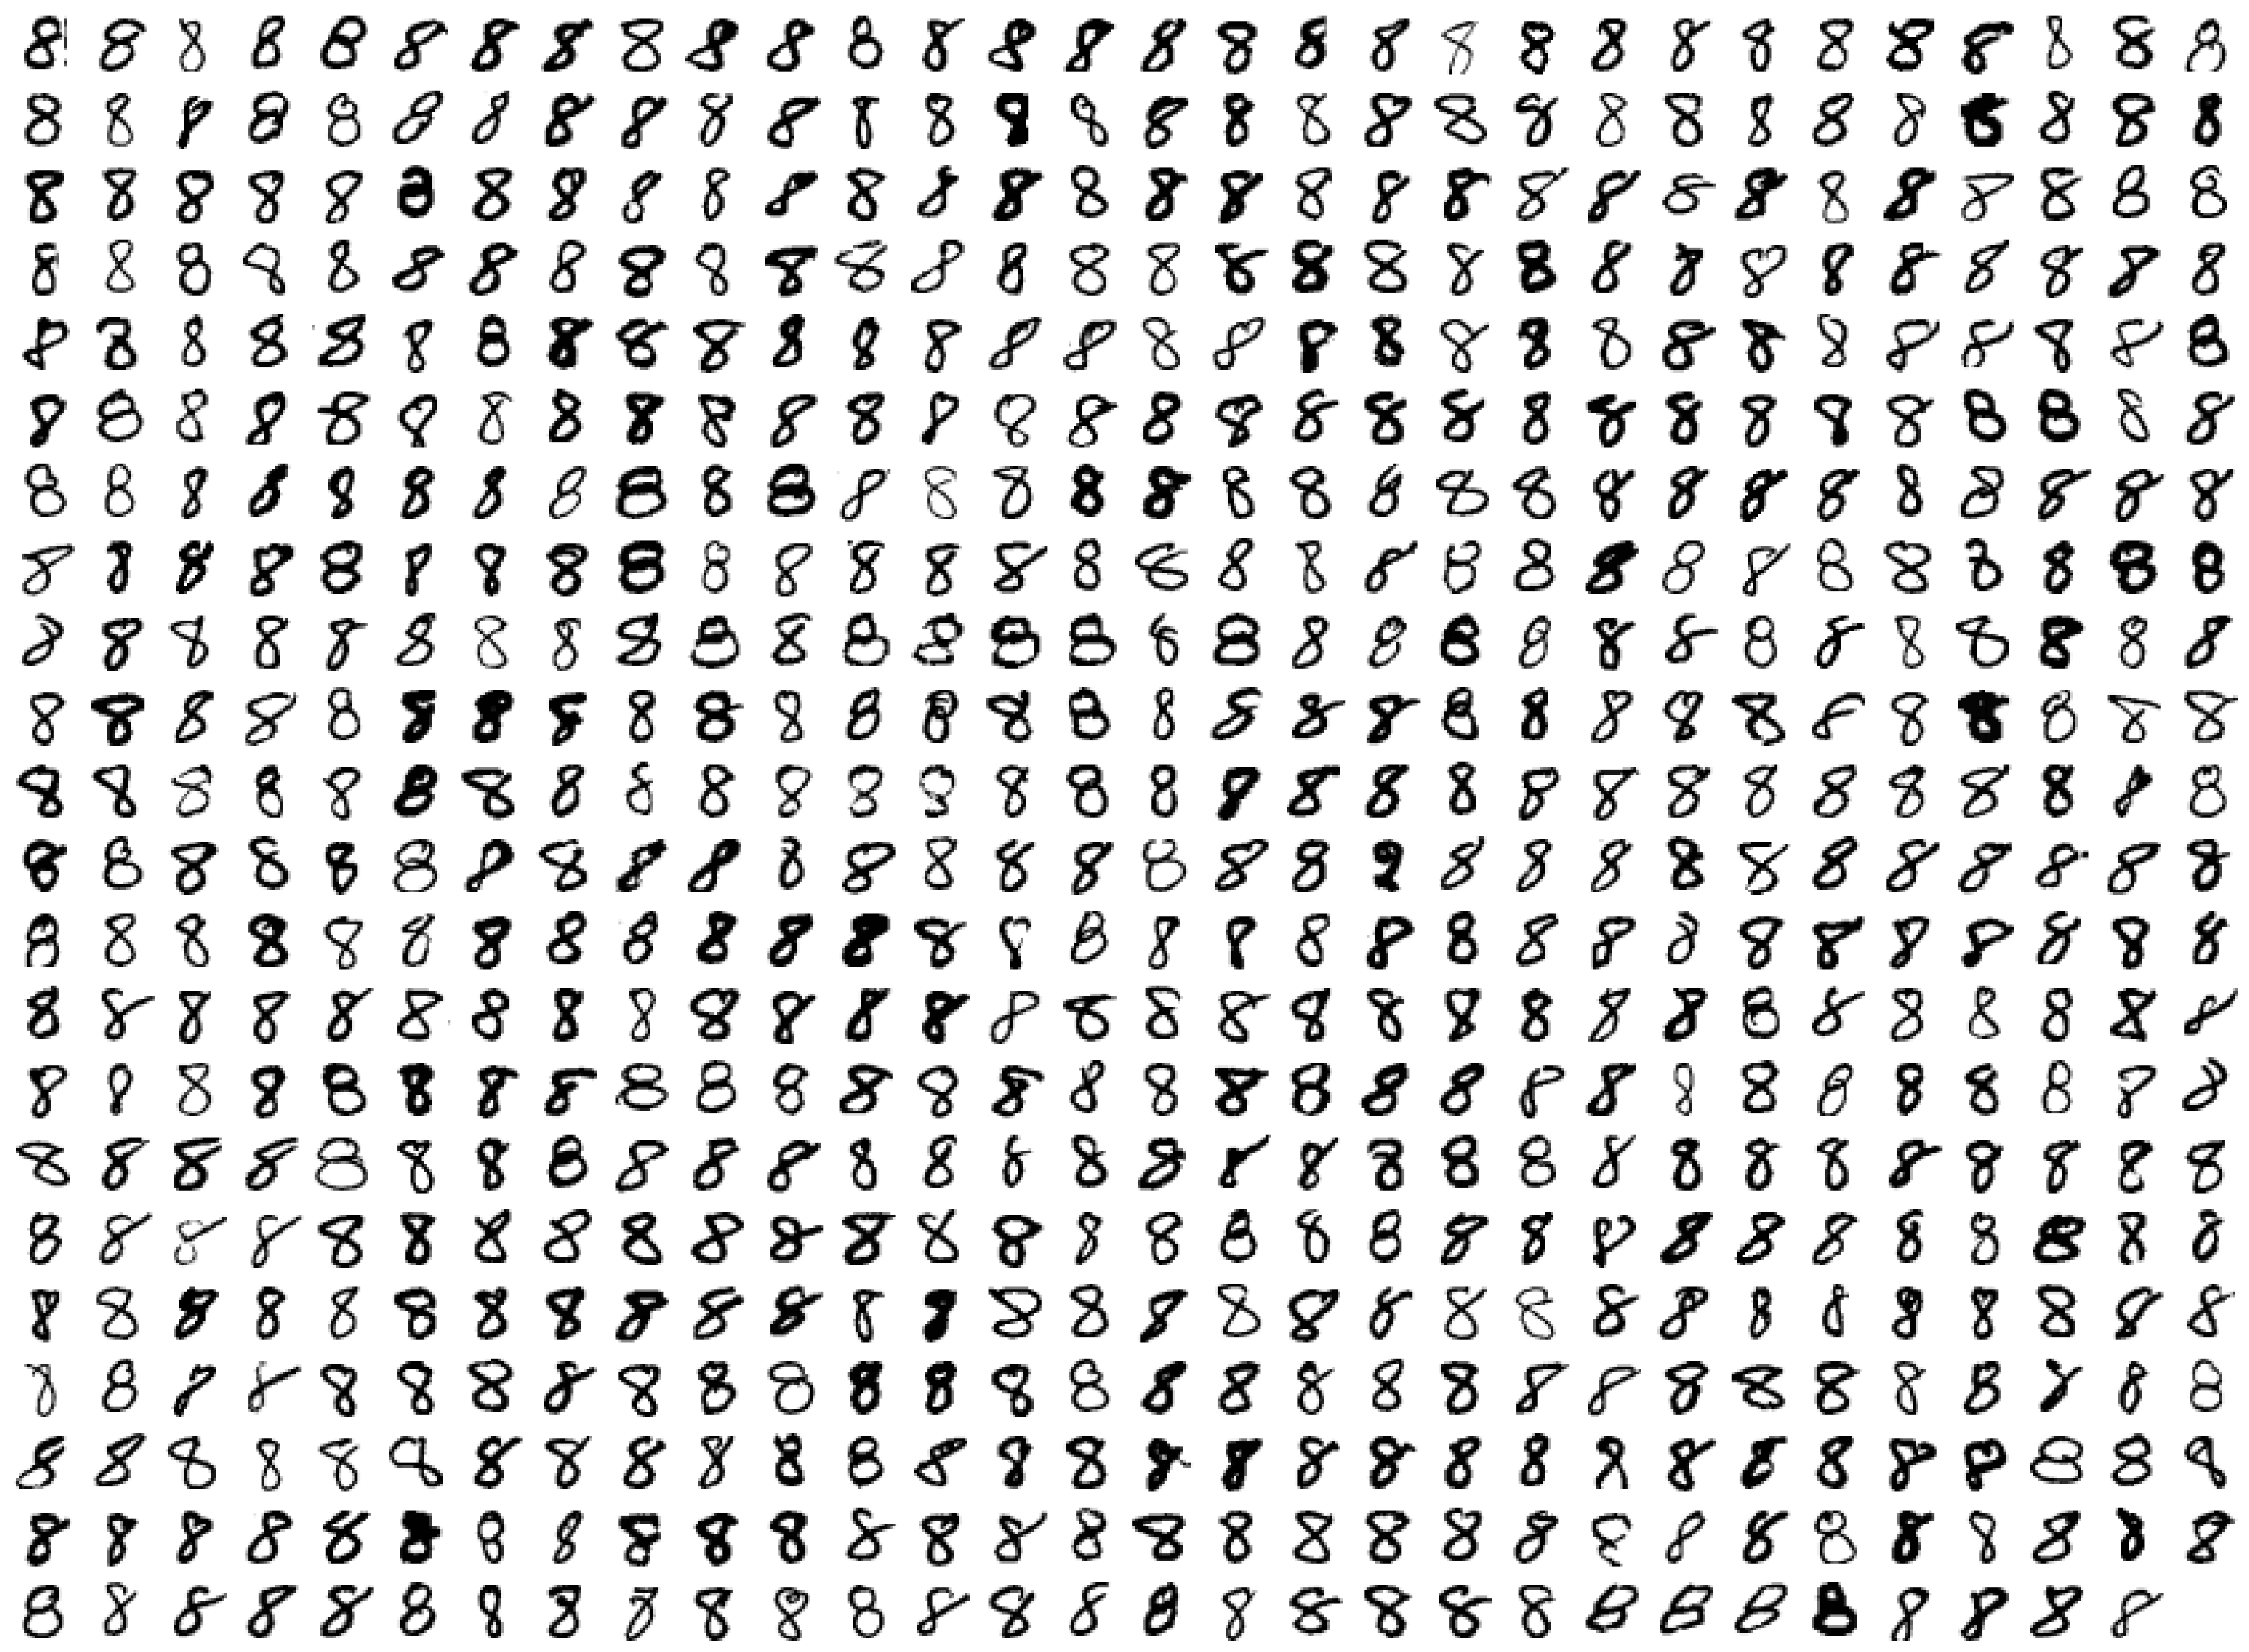

In [29]:
# display all the 8's classified as 5's
num = X_ba.shape[0]
plt.figure(figsize=(50,50))
plot_digits(X_ba[:num],plt, images_per_row = 30)

# Getting the activation values of the hidden nodesTo get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [30]:
from tensorflow.keras import models

# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_3>]

In [31]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  2 hidden node each has one activation value per training image

  62/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/opt/miniconda3/envs/LLMs/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/miniconda3/envs/LLMs/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/opt/miniconda3/envs/LLMs/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(24, 784))
  warnings.warn(msg)


(55000, 2)

In [32]:
hidden_node1_activation = hidden_layer_activation[:,0] # get activation values of the first hidden node
hidden_node2_activation = hidden_layer_activation[:,1] # get activation values of the second hidden node

print(f"The maximum activation value of the first hidden node is {hidden_node1_activation.max()}")
print(f"The maximum activation value of the second hidden node is {hidden_node2_activation.max()}")

The maximum activation value of the first hidden node is 38.41136169433594
The maximum activation value of the second hidden node is 37.58480453491211


In [33]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.     0.     0.     0.     0.0013 0.     0.     0.9071 0.     0.0915]
The sum of the probabilities is (approximately) 1.0


# Creating the scatterplotsWe combine the activation values of the two hidden nodes together with the corresponding predicted classes into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the DataFrame.

In [34]:
scatterPlot_df =  pd.DataFrame({'act_value_h1':hidden_node1_activation,
                                'act_value_h2':hidden_node2_activation,
                                'pred_class':pred_classes})
scatterPlot_df.head()

,act_value_h1,act_value_h2,pred_class
0,10.407614,0.000000,7
1,1.382859,1.287829,3
2,6.282458,2.464860,9
3,3.492875,7.506558,2
4,7.617334,8.780282,1


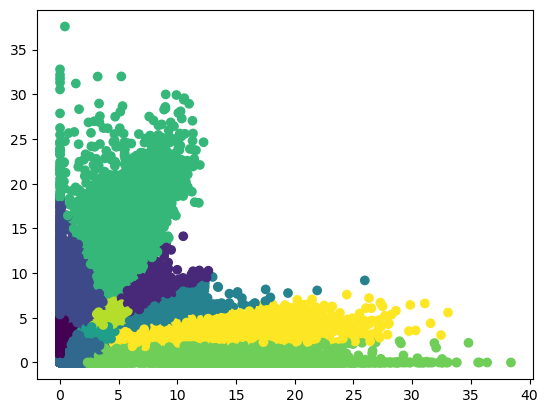

In [35]:
#plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1),ncol=1)
plt.scatter(scatterPlot_df.act_value_h1, 
            scatterPlot_df.act_value_h2, 
            c=scatterPlot_df.pred_class,
            label=scatterPlot_df.pred_class)
plt.show()

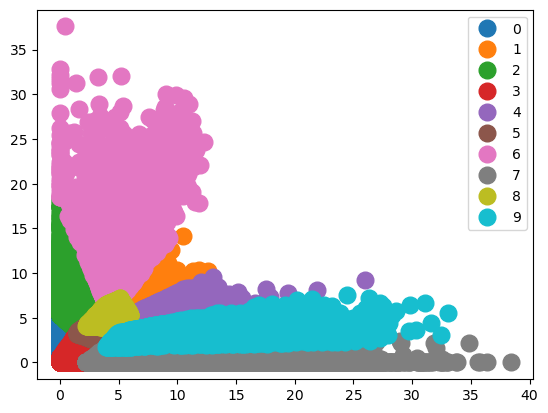

In [36]:
groups = scatterPlot_df.groupby('pred_class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.act_value_h1, group.act_value_h2, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()